In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from IPython.display import clear_output


In [14]:
# Get constants and stuff set up
rho_w = 1000 # kg/m^3 (water density)
rho_i = 900 #kg/m^3 (ice density)
g = 10 # m/s^2 (gravitational acceleration)
L = 3.3*10**5 # J/kg
K0 = 10**-24 # Pa^-3 s^-2
phi_s = 0.01 # surface slope
psi_0 = rho_w*g*phi_s 
n_prime = 0.1 # m^-1/3 s (hydraulic roughness)
f = 6.6*n_prime**2 
s_to_y = 60*60*24*365.25 

# Scales
s0 = 10*10**3 # m
Q0 = 1500 # m^3/s
m0 = Q0*psi_0/L 
S0 = (f*rho_w*g*Q0**2/psi_0)**(3/8)
N0 = (K0*rho_i*S0*L/(psi_0*Q0))**(-1/3)
t0 = rho_i*S0*L/(psi_0*Q0)
M0 = Q0/s0
h0 = 90

# Model Params
eps = s0*m0/(Q0*rho_i)
r = rho_i/rho_w
delta = N0/(s0*psi_0)

# Inputs
Q_in = 10/Q0
hL_pl1 = 1
beta_r = 0.9

tau_raw = 100000 # Pa
tau = tau_raw/N0
C = 2*10**-20 # For sliding law
alpha = C*(N0**3)*t0/s0 # For sliding law

# Need to adjust
lda = 3.2
psi = 1
M = 0.00

del_t = 0.01


In [15]:
# Initializing data storage arrays/resolution 
grid_space = 100
time_space = 100000

h = np.zeros(time_space)
S = np.zeros((time_space,grid_space))
Q = np.zeros((time_space,grid_space))
N = np.zeros((time_space,grid_space))
u = np.zeros((time_space,grid_space))

S[0,:] = 5*np.ones(grid_space)/S0
h[0] = 1/3
NL = beta_r*(1-h[0])
Nt = rho_i*g*1/N0
x = np.linspace(0,1,grid_space)
psi_var = psi*(1-3*np.exp(-20*x))


In [16]:
# Setting up functions
def Nye_NQ(x,y):
    S_i_var = np.interp(x,np.linspace(0,1,grid_space),S_i)
    S83 = S_i_var**(8/3)
    Q = y[1]
    N = y[0]
    psi_var_interp = np.interp(x,np.linspace(0,1,grid_space),psi_var)
    return np.vstack(((Q*np.abs(Q)/S83 - psi_var_interp)/delta, 
                      eps*(r-1)*np.abs(Q)**3/S83 + eps*S_i_var*N**3 + M))

In [17]:
# Setting up BCs
def bc_N(ya,yb):
    return np.array([ya[0]-NL, yb[0]-Nt])

In [18]:
%%time
# initial guess
y = np.zeros((2, x.size))
y[0,:]= np.sin(x*np.pi)
y[1,:]= 0.001 + M*x# solve initial step
S_i = S[0,:]
sol = solve_bvp(Nye_NQ, bc_N,x,y,verbose=2)
N[0,:]=sol.y[0]
Q[0,:]=sol.y[1]
u[0,:]=alpha*(tau**4)/N[0,:]
dSdx = np.gradient(S_i)/np.gradient(x)
S[1,:] = S_i + del_t*(np.abs(Q[0,:])**3/S_i**(8/3) - S_i*N[0,:]**3 - u[0,:]*dSdx)
h[1] = h[0] + del_t*lda*(Q_in-Q[0,0])/hL_pl1;
NL = beta_r*(1-h[1])
# Now we loop
for i in range(1,time_space-1):
    clear_output(wait=True)
    x = np.linspace(0,1,grid_space)
    y = np.zeros((2, x.size))
    y[0,:]= N[i-1,:]
    y[1,:]= Q[i-1,:]
    S_i = S[i,:]
    sol = solve_bvp(Nye_NQ, bc_N,x,y,tol=0.00000001,bc_tol=0.00000001,verbose=2,max_nodes=10000)
    if sol.status == 2:
        break
    N[i,:]=np.interp(x,sol.x,sol.y[0])
    Q[i,:]=np.interp(x,sol.x,sol.y[1])
    u[i,:]=alpha*(tau**4)/N[i,:]
    dSdx = np.gradient(S_i)/np.gradient(x)
    S[i+1,:] = S_i + del_t*(np.abs(Q[i,:])**3/S_i**(8/3) - S_i*N[i,:]**3 - 0*u[i,:]*dSdx)
    h[i+1] = h[i] + del_t*lda*(Q_in-Q[i,0])/hL_pl1
    if (h[i+1]<=0) or (S[i+1,:].any()<=0):
        break
    NL = beta_r*(1-h[i])

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          7.70e-03       0.00e+00          100            71       
       2          5.52e-04       0.00e+00          171            155      
       3          2.32e-05       0.00e+00          326            279      
       4          9.00e-07       0.00e+00          605            340      
       5          1.14e-07       0.00e+00          945            207      
       6          1.43e-08       0.00e+00         1152            32       
       7          1.00e-08       0.00e+00         1184             0       
Solved in 7 iterations, number of nodes 1184. 
Maximum relative residual: 1.00e-08 
Maximum boundary residual: 0.00e+00
CPU times: user 1h 14min 20s, sys: 5min 54s, total: 1h 20min 14s
Wall time: 1h 12min 52s


In [19]:
# Re-dimensionalizing everything
s_km = s0*np.linspace(0,1,grid_space)/1000
time_years = t0*del_t*np.arange(time_space)/s_to_y
h_meters = h0*h
Q_m3ps = Q0*Q
S_m2 = S0*S
N_Pa = N0*N
u_mpy = u*s0*s_to_y/t0

Text(0.5, 0, 'time, t (years)')

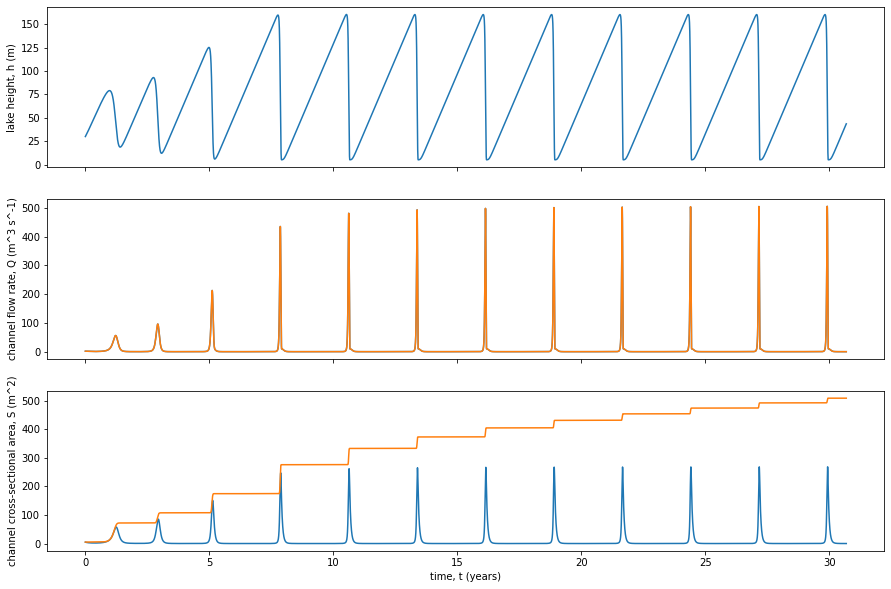

In [20]:
fig, ax = plt.subplots(3,figsize=[15,10],sharex=True)
#plt.xlim([0,5])
ax[0].plot(time_years,h_meters)
ax[0].set_ylabel('lake height, h (m)')

ax[1].plot(time_years,Q_m3ps[:,0])
ax[1].plot(time_years,Q_m3ps[:,-1])
ax[1].set_ylabel('channel flow rate, Q (m^3 s^-1)')

ax[2].plot(time_years,S_m2[:,0])
ax[2].plot(time_years,S_m2[:,-1])
ax[2].set_ylabel('channel cross-sectional area, S (m^2)')
ax[2].set_xlabel('time, t (years)')


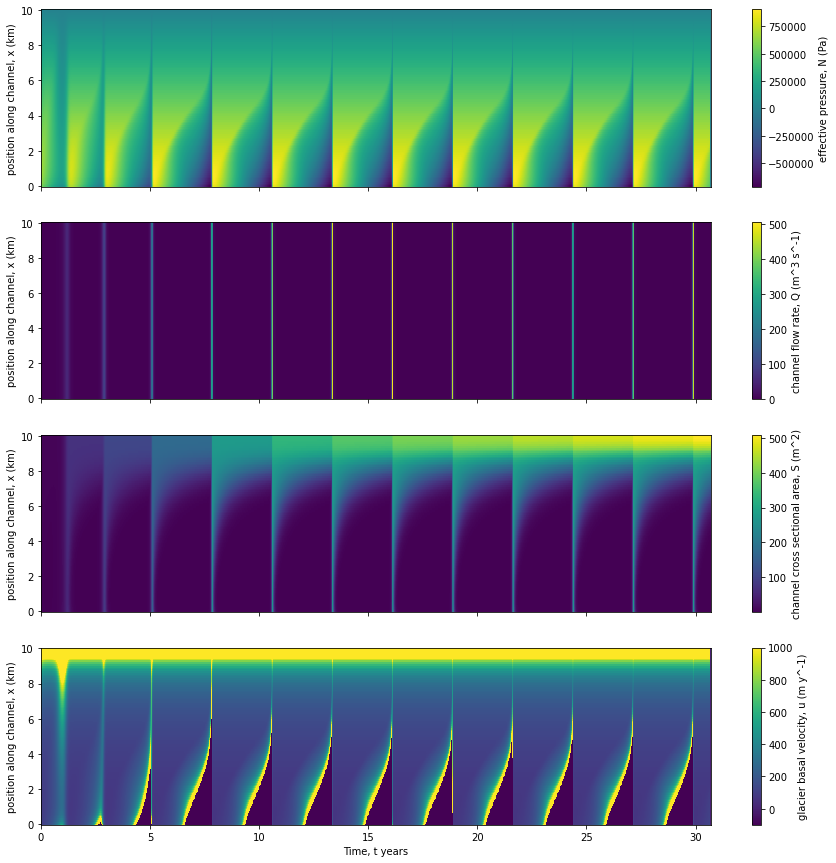

In [21]:
fig, ax = plt.subplots(4,figsize=[15,15],sharex=True)
#plt.xlim([0,5])
p0 = ax[0].pcolormesh(time_years,s_km,N_Pa.transpose(),shading='auto')
ax[0].set_ylabel('position along channel, x (km)')
cbar0 = fig.colorbar(p0,ax=ax[0])
cbar0.set_label('effective pressure, N (Pa)')

p1 = ax[1].pcolormesh(time_years,s_km,Q_m3ps.transpose(),shading='auto')
ax[1].set_ylabel('position along channel, x (km)')
cbar1 = fig.colorbar(p1,ax=ax[1])
cbar1.set_label('channel flow rate, Q (m^3 s^-1)')

p2 = ax[2].pcolormesh(time_years,s_km,S_m2.transpose(),shading='auto')
ax[2].set_ylabel('position along channel, x (km)')
cbar2 = fig.colorbar(p2,ax=ax[2])
cbar2.set_label('channel cross sectional area, S (m^2)')

p3 = ax[3].pcolormesh(time_years,s_km,u_mpy.transpose(),vmin=-100,vmax=1000,shading='auto')
ax[3].set_ylabel('position along channel, x (km)')
ax[3].set_xlabel('Time, t years')
cbar3 = fig.colorbar(p3,ax=ax[3])
cbar3.set_label('glacier basal velocity, u (m y^-1)')